# NLP Going Deeper 12 : 번역 모델을 활용한 챗봇 구현 (Practice Part)

클라우드 환경에서 준비된 데이터를 아래와 같이 심볼릭 링크를 걸어 준비합니다.

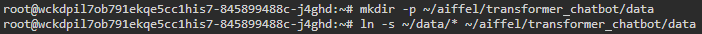

한편, 챗봇을 만들기 위해서는 번역을 할 수 있는 모델이 있어야 합니다. 우선 접근성이 좋은 영어-스페인어 데이터를 사용해봅시다.

## 라이브러리 및 데이터 준비하기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import os
import io
import time
import random

from sklearn.model_selection import train_test_split

print('텐서플로 버전 :', tf.__version__)

텐서플로 버전 : 2.4.1


In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

with open(path_to_file, "r") as f:
    corpus = f.read().splitlines()

print("Data Size:", len(corpus))
print("Example:")

for sen in corpus[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


이번엔 한-영 번역 때와 다르게, **두 언어가 단어 사전을 공유하도록 합니다.** 영어와 스페인어 모두 알파벳으로 이뤄지는 데다가 같은 인도유럽어족이기 때문에 기대할 수 있는 효과가 많습니다. 후에 챗봇을 만들 때에도 질문과 답변이 모두 한글로 이루어질 예정이기 때문에 Embedding 층을 공유하는 것이 성능 향상에 도움이 됩니다.

토큰화에는 Sentencepiece를 사용할 것이고 단어 사전 수는 20,000으로 설정하겠습니다.

## 토큰화 하기

In [3]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="spa-eng",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer
print("무사통과🛸")

무사통과🛸


In [4]:
cleaned_corpus = list(set(corpus)) 

VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(cleaned_corpus, VOCAB_SIZE)
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

True

위에서 두 언어 사이에 단어 사전을 공유하기로 했죠?

따라서 Encoder와 Decoder의 전용 토크나이저를 만들지 않고, 방금 만들어진 토크나이저를 두 언어 사이에서 공유하게 하겠습니다.

토크나이저가 준비되었으니 본격적으로 데이터를 토큰화하도록 하겠습니다. **문장부호와 대소문자 등을 정제하는 preprocess_sentence() 함수를 정의해 데이터를 정제하고, 정제된 데이터가 50개 이상의 토큰을 갖는 경우 제거하도록 합니다.**

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()

    sentence = re.sub(r"([?.!,¿¡])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿¡]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence
print("정제 함수 구현 완료🛸")

정제 함수 구현 완료🛸


In [6]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

for pair in tqdm_notebook(cleaned_corpus):
    src, tgt = pair.split('\t')

    src_tokens = tokenizer.encode_as_ids(preprocess_sentence(src))   # encode_ad_ids() 는 문자열을 숫자로 분할합니다.
    tgt_tokens = tokenizer.encode_as_ids(preprocess_sentence(tgt))

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)

len(src_corpus)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/118964 [00:00<?, ?it/s]

118951

**list 자료형도 단숨에 패딩 작업을 해주는 pad_sequences() 함수를 사용하여 빠르게 데이터셋을 완성하도록 하겠습니다.** 그리고 다음 스텝에서도 그대로 활용할 예정이니 딱 1%의 데이터만 테스트 셋으로 설정하겠습니다.

In [7]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 117761 enc_val : 1190
dec_train : 117761 dec_val : 1190


## 트랜스포머 구현하기

지난 노드에서 다뤘던 트랜스포머를 이번 노드에서도 사용할 것입니다.

트랜스포머의 구현은 아래 자료를 참고하여 수행해 봅니다.

**1. 트랜스포머 기본 구조 - https://wikidocs.net/31379**

**2. PyTorch로 트랜스포머 구현 Part.1 - https://paul-hyun.github.io/transformer-01/**

**3. PyTorch로 트랜스포머 구현 Part.2 - https://paul-hyun.github.io/transformer-02/**

**4. PyTorch로 트랜스포머 구현 Part.3 - https://paul-hyun.github.io/transformer-03/**

**5. 어텐션 레이어 구현 - https://rubikscode.net/2019/08/05/transformer-with-python-and-tensorflow-2-0-attention-layers/**

### Positional Encoding 함수 구현

In [8]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### 마스크 생성

In [9]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### Multi-head Attention

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

### Position-wise Feed Forward Network

In [11]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

print('여기까지 무사통과~😘😘')

여기까지 무사통과~😘😘


### Encoder Layer 구현

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Decoder Layer 구현

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder 구현

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder 구현

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
    
print('이제 정말 거의 다 왔어요! 화이팅😉😉')

이제 정말 거의 다 왔어요! 화이팅😉😉


### Transformer 전체 모델 조립하기

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
    
print('Transformer 전체 구조 완성!😄😄')

Transformer 전체 구조 완성!😄😄


### 모델 인스턴스 생성하기

In [17]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

## 트랜스포머 모델 학습 시키기

### Learning Rate Scheduler

In [18]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

### Learning Rate & Optimizer

In [19]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

### Loss Function

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Train Step

In [21]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

print('이제 곧 훈련입니다! 여기까지 고생많았어요~😻')

이제 곧 훈련입니다! 여기까지 고생많았어요~😻


### 모델 학습

In [22]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1841 [00:00<?, ?it/s]

  0%|          | 0/1841 [00:00<?, ?it/s]

  0%|          | 0/1841 [00:00<?, ?it/s]

## 번역 성능 측정 지표 : BLEU Score

**관련 링크 : https://donghwa-kim.github.io/BLEU.html**

### NLTK를 활용한 BLEU Score

NLTK는 Natural Language Tool Kit의 준말로 이름부터 자연어 처리에 큰 도움이 될 것 같은 라이브러리입니다.

**NLTK는 BLEU Score를 지원**하니 이를 활용하도록 합니다. 만일 **설치되어 있지 않다면 pip install nltk 명령어로 간단하게 설치**할 수 있습니다.

In [23]:
from nltk.translate.bleu_score import sentence_bleu

reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문 :", reference)
print("번역문 :", candidate)
print("BLEU Score :", sentence_bleu([reference], candidate))

원문 : ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문 : ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score : 8.190757052088229e-155


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


**BLEU Score는 0~1 사이의 값을 가지지만, 100을 곱한 백분율 값으로 표기하는 경우도 많습니다.** BLEU Score의 점수대별 해석에 대해서는 하기 링크를 참고해 주세요.

**https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu**

BLEU Score가 50점을 넘는다는 것은 정말 멋진 번역을 생성했다고 볼 수 있습니다. 보통의 논문에서 제시하는 BLEU Score는 20점에서 높으면 40점을 바라본다고 합니다.

하지만 방금 나온 점수는 사실상 0점에 가까운 결과를 보입니다. 과연 무엇이 잘못되었을까요?

한편 BLEU Score의 정의로 돌아가 보면, BLEU Score가 N-gram으로 점수를 측정한다고 합니다. 수식은 다음과 같이 나타냅니다.

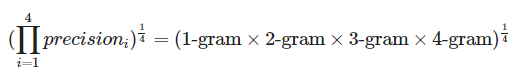

1-gram부터 4-gram까지의 점수(Precision)를 모두 곱한 후, 루트를 두 번 씌우면 BLEU Score가 됩니다. 진정 멋진 번역이라면, 모든 N-gram에 대해서 높은 점수를 얻었을 것입니다!

그렇다면 위에서 살펴본 예시에서는 각 N-gram이 점수를 얼마나 얻었는지 확인해 보도록 합시다.

**weights의 디폴트 값은 [0.25, 0.25, 0.25, 0.25]로 1-gram부터 4-gram까지의 점수에 가중치를 동일하게 주는 것이지만, 만약 이 값을 [1, 0, 0, 0]으로 바꿔주면 BLEU Score에 1-gram의 점수만 반영하게 됩니다.**

In [24]:
print("1-gram :", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram :", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram :", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram :", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram : 0.5
2-gram : 0.18181818181818182
3-gram : 2.2250738585072626e-308
4-gram : 2.2250738585072626e-308


**0점에 가까운 BLEU Score가 나오는 원인은 바로 3-gram와 4-gram에서 거의 0점을 받았기 때문입니다.**

위 예시에서 번역문 문장 중 어느 3-gram도 원문의 3-gram과 일치하는 것이 없다고 볼 수 있습니다. 2-gram이 0.18이 나오는 것은 원문의 11개 2-gram 중에 약 2개만이 번역문에서 재현되었기 때문이라고 볼 수 있습니다.

하지만 만약 nltk를 낮은 버전으로 사용할 경우, 간혹 이런 경우에 3-gram, 4-gram 점수가 1이 나와서 전체적인 BLEU 점수가 50점 이상으로 의도치 않게 매우 높게 나오게 될 수도 있으니 조심해야 합니다. (위의 BLEU Score 공식과 곁들여 보세요.)

예전 버전에서는 위 수식에서 어떤 N-gram이 0의 값을 갖는다면 그 하위 N-gram 점수들이 곱했을 때 모두 소멸해버리기 때문에 일치하는 N-gram이 없더라도 점수를 1.0 으로 유지하여 하위 점수를 보존하게끔 구현되어 있었습니다.

하지만 1.0 은 모든 번역을 완벽히 재현했음을 의미하기 때문에 총점이 의도치 않게 높게 나올 수 있습니다. 그럴 경우에는 **BLEU Score가 바람직하지 못할 것(Undesirable)이라는 경고문이 추가**되긴 합니다.

### SmoothingFunction()으로 BLEU Score 보정하기

**BLEU Score 계산 시 특정 N-gram이 0점이 나와서 BLEU가 너무 커지거나 작아지는 쪽으로 왜곡되는 문제를 보완하기 위해 SmoothingFunction() 을 사용하고 있습니다.** Smoothing 함수는 모든 Precision에 아주 작은 epsilon 값을 더해주는 역할을 하는데, 이로써 0점이 부여된 Precision도 완전한 0이 되지 않으니 점수를 1.0 으로 대체할 필요가 없어지게 되면서 우리의 원래 의도대로 점수가 계산되게 됩니다.

진실된 BLEU Score를 확인하기 위해, 이제 SmoothingFunction() 을 적용해 봅시다. 아래 코드에서는 SmoothingFunction().method1을 사용해 보겠습니다. 자신만의 Smoothing 함수를 구현해서 적용할 수도 있겠지만, 사실 nltk에서는 method0부터 method7까지를 이미 제공하고 있습니다.

8개의 method에 대한 자세한 설명은 아래 링크를 참조하시면 됩니다.

**https://www.nltk.org/_modules/nltk/translate/bleu_score.html**

참고로, **sentence_bleu() 함수에 smoothing_function=None을 적용하면 method0 세팅이 기본 적용됩니다**

In [26]:
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1 :", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2 :", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3 :", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4 :", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total :", calculate_bleu(reference, candidate))

BLEU-1 : 0.5
BLEU-2 : 0.18181818181818182
BLEU-3 : 0.010000000000000004
BLEU-4 : 0.011111111111111112

BLEU-Total : 0.05637560315259291


SmoothingFunction()로 BLEU score를 보정한 결과, 새로운 BLEU 점수는 5점 정도입니다. 그나마 보정해서 이 정도 나온 것 같습니다.

여기서 BLEU-4가 BLEU-3보다 조금이나마 점수가 높은 이유는 한 문장에서 발생하는 3-gram 쌍의 개수와 4-gram 쌍의 개수를 생각해 보면 이해할 수 있습니다. 각 Precision을 N-gram 개수로 나누는 부분의 차이에 주목합시다.

### 트랜스포머 모델의 번역 성능 알아보기

위 예시를 **조금만 응용**하면 우리가 훈련한 모델이 얼마나 번역을 잘하는지 평가할 수 있습니다.

아까 1%의 데이터를 테스트 셋으로 빼 둔 것을 기억하시죠? 테스트 셋으로 **모델의 BLEU Score를 측정하는 함수 eval_bleu() 를 구현**하도록 합시다.

먼저, **번역을 생성하기 위해 evaluate() 함수와 translate() 함수를 정의**합니다.

In [27]:
# evaluate 함수 정의
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)  # 문자열을 token으로 분할합니다. 
    tokens = src_tokenizer.encode_as_ids(sentence)  # 문자열을 숫자로 분할합니다.

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()  # predictions에 소프트맥스 함수를 적용하여 가장 큰 값의 인덱스를 predicted_id로 저장합니다.

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  # 숫자를 문자열로 복원합니다.  
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

print("evaluate 함수 정의 완료🛸")

evaluate 함수 정의 완료🛸


In [28]:
# translate 함수 정의
def translate(sentence, model, src_tokenizer, tgt_tokenizer):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    return result

print("translate 함수 정의 완료🛸")

translate 함수 정의 완료🛸


이제 함수 **eval_bleu()** 를 구현합니다.

In [29]:
def eval_bleu(src_corpus, tgt_corpus, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm_notebook(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]

        src_sentence = tokenizer.decode_ids((src_tokens.tolist()))  
        tgt_sentence = tokenizer.decode_ids((tgt_tokens.tolist()))

        reference = preprocess_sentence(tgt_sentence).split()
        candidate = translate(src_sentence, transformer, tokenizer, tokenizer).split()

        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", candidate)
            print("Real: ", reference)
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("eval_bleu 함수 구현 완료~👍👍")

eval_bleu 함수 구현 완료~👍👍


주어진 병렬 말뭉치 src_corpus 와 tgt_corpus 를 인덱스 순으로 살피며 소스 토큰과 타겟 토큰을 각각 원문으로 Decoding 하고, 소스 문장을 translate() 함수를 통해 번역한 후 생성된 번역문과 타겟 문장의 BLEU Score를 측정합니다.

측정된 score 는 total_score 에 합산되어 최종적으로 주어진 병렬 말뭉치의 평균 BLEU Score를 출력하게 됩니다.

**verbose 변수를 True** 로 주면 번역문과 원문, 매 스텝의 점수를 확인할 수 있습니다. 간단히 3 epoch만 돌려봅시다.

In [30]:
eval_bleu(enc_val[:3], dec_val[:3], True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/3 [00:00<?, ?it/s]

Source Sentence:  we ll live like kings ......................................
Model Prediction:  [',', 's', ',', 's']
Real:  ['viviremos', 'como', 'reyes', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
Score: 0.000000

Source Sentence:  it looks like they re satisfied with the result ....................................
Model Prediction:  [',', 's', ',', 's']
Real:  ['parece', 'que', 'est', 'n', 'satisfechos', 'con', 'el', 'resultado', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
Score: 0.000000

Source Sentence:  tom lost a lot of weight ......................................
Model Prediction:  [',', 's', ',', 's']
Real:  ['tom', 'baj', 'mucho', 'de', 'peso', '.', '.', '.', '.', '.', '

3 Epoch밖에 학습하지 않아서인지 성능이 좋지 않습니다. 우선 표본이 적은 것일 수도 있으니, 좀 더 많은 데이터로 측정해 보겠습니다.

다만, **전체 테스트 셋으로 측정하는 것은 시간이 제법 걸리기 때문에 1/10만 사용해서 실습**하는 걸 권장하고 있습니다.

**enc_val[::10] 의 [::10] 은 리스트를 10개씩 건너뛰어 추출하라는 의미**로 지금 적용하기에 적절할 것입니다. **출력문 지옥을 피하고 싶으시다면 verbose 를 False 로 설정**하는 것도 하나의 방법이 될 수 있습니다

In [31]:
eval_bleu(enc_val[::10], dec_val[::10], verbose=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/119 [00:00<?, ?it/s]

Num of Sample: 119
Total Score: 2.3022487024336227e-07


## 번역 생성 측정 기법 : Beam Search Decoder

이 멋진 평가 지표를 더 멋지게 사용하는 방법은 **모델의 생성 기법에 변화를 주는 것**입니다.

Greedy Decoding 대신 새로운 기법을 적용하여 지금의 모델을 더 잘 평가할 수 있게 하는 것이 좋겠습니다.

Beam Search에 대해서 예시로 활용했던 코드를 살펴봅시다.

In [32]:
import math

def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

In [33]:
# 테스트 해보자!
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


사실 이 예시는 Beam Search를 설명하는 데에는 더없이 적당하지만 실제로 모델이 문장을 생성하는 과정과는 거리가 멉니다. 당장 모델이 문장을 생성하는 과정만 떠올려도 위의 prob_seq 처럼 확률을 정의할 수 없겠다는 생각이 머리를 스칠 것입니다. 각 단어에 대한 확률은 prob_seq 처럼 한 번에 정의가 되지 않고 이전 스텝까지의 단어에 따라서 결정되기 때문입니다.

간단한 예시로, Beam Size가 2이고 Time-step이 2인 순간의 두 문장이 나는 밥을 , 나는 커피를 이라고 한다면 세 번째 단어로 먹는다 , 마신다 를 고려할 수 있습니다. 이때, 전자에서 마신다 에 할당하는 확률과 후자에서 마신다 에 할당하는 확률은 각각 이전 단어들인 나는 밥을 , 나는 커피를 에 따라서 결정되기 때문에 서로 독립적인 확률을 갖습니다. 예컨대 후자가 마신다 에 더 높은 확률을 할당할 것을 알 수 있죠! 위 소스에서처럼 "3번째 단어는 항상 [마신다: 0.3, 먹는다:0.5, ...] 의 확률을 가진다!" 라고는 할 수 없다는 것입니다.

따라서 Beam Search를 생성 기법으로 구현할 때에는 분기를 잘 나눠줘야 합니다. Beam Size가 5라고 가정하면 맨 첫 단어로 적합한 5개의 단어를 생성하고, 두 번째 단어로 각 첫 단어(5개 단어)에 대해 5순위까지 확률을 구하여 총 25개의 문장을 생성합니다. 그 25개의 문장들은 각 단어에 할당된 확률을 곱하여 구한 점수(존재 확률)를 가지고 있으니 각각의 순위를 매길 수 있을 것이고, 점수 상위 5개의 표본만 살아남아 세 번째 단어를 구할 자격을 얻게 됩니다.

위 과정을 반복하면 최종적으로 점수가 가장 높은 5개의 문장을 얻게 됩니다. 물론 Beam Size를 조절해 주면 그 수는 유동적으로 변하게 됩니다.

### Beam Search Decoder 작성 및 평가하기

각 단어의 확률값을 계산하는 calc_prob()와 Beam Search를 기반으로 동작하는 beam_search_decoder() 를 구현하고 생성된 문장에 대해 BLEU Score를 출력하는 beam_bleu() 를 구현합니다.

**구현에는 이전에 만들었던 evaluate 함수와 아래 입력, 출력 예시를 참고하세요.**

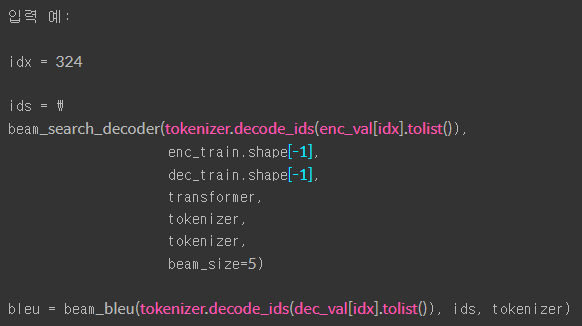

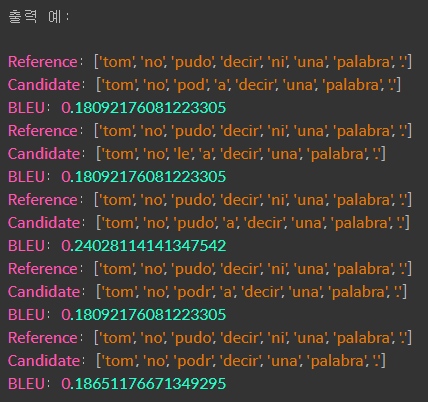

In [34]:
# calc_prob 함수 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [35]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.long)
    pred = np.zeros((beam_size, tgt_len), dtype=np.long)

    eos_flag = np.zeros((beam_size, ), dtype=np.long)
    scores = np.ones((beam_size, ))

    pred[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    return pred

In [36]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# calculate_bleu 함수 구현
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

# beam_bleu 함수 구현
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

In [37]:
idx = 324

ids = \
beam_search_decoder(tokenizer.decode_ids(enc_val[idx].tolist()),
                    enc_train.shape[-1],
                    dec_train.shape[-1],
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(tokenizer.decode_ids(dec_val[idx].tolist()), ids, tokenizer)

Reference: ['ese', 'hombre', 'no', 'me', 'dijo', 'su', 'nombre', '........................................']
Candidate: [',', 's', ',']
BLEU: 0
Reference: ['ese', 'hombre', 'no', 'me', 'dijo', 'su', 'nombre', '........................................']
Candidate: [',', 's', ',', 's']
BLEU: 0
Reference: ['ese', 'hombre', 'no', 'me', 'dijo', 'su', 'nombre', '........................................']
Candidate: [',', 's', ',', 's']
BLEU: 0
Reference: ['ese', 'hombre', 'no', 'me', 'dijo', 'su', 'nombre', '........................................']
Candidate: [',', ',', ',']
BLEU: 0
Reference: ['ese', 'hombre', 'no', 'me', 'dijo', 'su', 'nombre', '........................................']
Candidate: [',', 's', ',', 'ss']
BLEU: 0


## 데이터 부풀리기

이번 스텝에서는 **Data Augmentation, 그중에서도 Embedding을 활용한 Lexical Substitution을 구현**해 봅니다. **gensim 라이브러리를 활용**하면 어렵지 않게 접근하실 수 있습니다.

컴퓨터에 gensim이 설치되어 있지 않은 경우, 먼저 **pip install gensim**을 Cloud Shell에 입력하여 설치를 진행하세요.

**gensim 에 사전 훈련된 Embedding 모델을 불러오는 것**은 두 가지 방법이 있습니다.

1. 직접 모델을 다운로드해 load 하는 방법
2. gensim 이 자체적으로 지원하는 downloader 를 활용해 모델을 load 하는 방법

한국어는 gensim 에서 지원하지 않으므로 두 번째 방법을 사용할 수 없지만, 영어일 경우에는 사용이 가능할 것입니다.

아래 웹페이지의 Available data → Model 부분에서 공개된 모델의 종류를 확인할 수 있습니다.

**https://github.com/RaRe-Technologies/gensim-data**

대표적으로 사용되는 Embedding 모델은 word2vec-google-news-300 이지만 용량이 커서 다운로드에 많은 시간이 소요되므로 실습과정에서는 사용하지 않고, 우리는 **적당한 사이즈의 모델인 glove-wiki-gigaword-300 을 사용하겠습니다.**

아래 소스를 실행해 사전에 훈련된 Embedding 모델을 다운로드해 주세요.

In [38]:
# 사전 훈련된 Embedding 모델 다운로드 하기
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


불러온 모델은 아래와 같이 활용할 수 있습니다.

In [39]:
wv.most_similar("banana")

[('bananas', 0.6691170930862427),
 ('mango', 0.5804104208946228),
 ('pineapple', 0.5492372512817383),
 ('coconut', 0.5462778806686401),
 ('papaya', 0.541056752204895),
 ('fruit', 0.52181077003479),
 ('growers', 0.4877638816833496),
 ('nut', 0.48399588465690613),
 ('peanut', 0.48062023520469666),
 ('potato', 0.48061180114746094)]

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하면 그것으로 Lexical Substitution은 완성됩니다. 가볍게 확인해 봅시다.

In [40]:
import random

sample_sentence = "you know ? all you need is attention ."
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From :", sample_sentence)
print("To :", result)

From : you know ? all you need is attention .
To : you know ? all you needs is attention . 


### Lexical Substitution 구현하기

**다음의 처리 방법을 참고하여 Lexical Substitution을 구현해 봅시다.**

1. 입력된 문장을 Embedding 유사도를 기반으로 Augmentation하여 반환하는 lexical_sub() 함수 구현
2. 구현한 함수를 활용해 3,000개의 영문 데이터를 Augmentation 하고 결과 확인
3. 단어장에 포함되지 않은 단어가 들어오는 경우, 문장 부호에 대한 치환이 발생하는 경우 등의 예외는 자유롭게 처리

해당 작업을 수행한 예시는 다음과 같습니다.

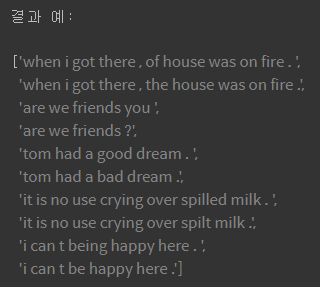

In [41]:
print('시간 좀 걸려요~ 화이팅🔥')

# lexical_sub 함수 구현
def lexical_sub(sentence, word2vec):
    import random
    
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res


from tqdm import tqdm_notebook

new_corpus = []

for idx in tqdm_notebook(range(3000)):
    old_src = tokenizer.decode_ids(src_corpus[idx])

    new_src = lexical_sub(old_src, wv)

    if new_src is not None: new_corpus.append(new_src)

    new_corpus.append(old_src)

print(new_corpus[:10])

시간 좀 걸려요~ 화이팅🔥


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3000 [00:00<?, ?it/s]

['i rang of bell and waited . ', 'i rang the bell and waited .', 'bob will be disappointed if you don t go to his party . ', 'tom will be disappointed if you don t go to his party .', "i want to share something with 'll . ", 'i want to share something with you .', 'bob s kindness affected her . ', 'tom s kindness affected her .', 'the first atomic bomb was dropping on japan . ', 'the first atomic bomb was dropped on japan .']
